In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Maja's model

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5*2 # (age, gender)
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)] # 0-4 age vars, 5-9 sex vars
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
# add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4])) # important
sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]])
sat.addition_does_not_overflow([x[5], x[5], x[7], x[8], x[8]])
for i in range(5):
    sat.multi_does_not_overflow([x[i],x[i+5]]) # this is in case of multiplication


## old model
# g.add(x[2] == 30)
# g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5)
# g.add(ULE(x[0],30)) # ULE is <= (using simply <= does not work)
# g.add(ULE(x[1],30))
# g.add(ULE(30,x[3]))
# g.add(ULE(30,x[4]))
# g.add(ULE(x[3],125))
# g.add(ULE(x[4],125))

## alternative
# this are binary (obviusly only for the purpose of the example)
# FEMALE = 0
# MALE = 1
for i in range(5,10):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],1))


# establish an order to set the median
g.add(ULE(0,x[0]))
g.add(ULE(x[0],x[1]))
g.add(ULE(x[1],x[2]))
g.add(ULE(x[2],x[3]))
g.add(ULE(x[3],x[4]))
g.add(ULE(x[4],125))

g.add(x[2] == 30) # median

g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) # average age

g.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

g.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males


As a sanity check, we verify that the SMT problem has a solution

In [3]:
# sanity check (optional)
solve(g)

[x80 = False,
 x04 = False,
 x06 = False,
 x03 = False,
 x51 = False,
 x45 = False,
 x11 = True,
 x43 = True,
 x40 = False,
 x34 = True,
 x13 = True,
 x30 = False,
 x52 = False,
 x10 = False,
 x32 = False,
 x41 = False,
 x44 = False,
 x01 = True,
 x33 = True,
 x35 = True,
 x42 = False,
 x70 = True,
 x36 = False,
 x90 = True,
 x02 = False,
 x46 = True,
 x12 = True,
 x60 = True,
 x31 = False,
 x14 = True,
 x86 = False,
 x17 = False,
 x75 = False,
 x64 = False,
 x67 = False,
 x96 = False,
 x92 = False,
 x87 = False,
 x82 = False,
 x77 = False,
 x73 = False,
 x66 = False,
 x65 = False,
 x62 = False,
 x81 = False,
 x37 = False,
 x16 = False,
 x63 = False,
 x94 = False,
 x76 = False,
 x84 = False,
 x85 = False,
 x71 = False,
 x83 = False,
 x95 = False,
 x91 = False,
 x15 = False,
 x97 = False,
 x74 = False,
 x61 = False,
 x93 = False,
 x72 = False,
 x50 = False,
 x57 = False,
 x56 = False,
 x53 = False,
 x55 = False,
 x07 = False,
 x54 = False,
 x05 = False,
 x00 = False,
 x1 = 30,
 x4 = 72,

## Bit-blasting

The function below bit-blasts the problem and stores it in CNF form in the specified directory and file. The bit-blasted problem is stored in DIMACS format. This is one for the input formats that `spur` supports.

The `save_dimacs` function returns a pair with two elements. 

The first one is that number of variables in the bit-blasted problem (`num_variables`)---do not confuse this variable with `num_vars`, which is the number of variables in the original SMT problem. The resulting bit-blasted problem is a SAT problem.

The second element `variables_number` is a map `int -> Z3_VAR` that assigs a natural number to each bit-blasted variable. This map is necessary to reverse the bit-blasting process after obtaining the samples from `spur`.

In [4]:
input_dir = 'spur_input'
input_file = 'Database1.cnf'
(num_variables, variables_number) = sat.save_dimacs(g, 
                                                    f'{input_dir}/{input_file}')

Here we call `spur` using the input file created in the previous step. We instruct it to generate 10000 samples. The output samples are stored in the same directory as the input file, and the output file is named `samples_<input_file>.txt`.

In [5]:
num_samples   = 10000
sat.execute_spur(f'{input_dir}/{input_file}',num_samples=num_samples)

Using default filename: "spur_input/samples_Database1.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/Database1.cnf
Output File: spur_input/samples_Database1.txt

Preprocessing ... DONE
variables (all/used/free): 	938/938/0
independent support size:  	0
clauses (all/long/binary/unit): 4060/3205/801/54
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1959 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1959 MB

Sample #1 of 181 is already a complete assignment.  Continuing...
Completing sample #2 of 181 which has 12 variables unset and 20 samples.
Completing sample #3 of 181 which has 23 variables unset and 10 samples.
Completing sample #4 of 181 which has 11 variables unset and 14 samples.
Completing sample #5 of 181 which has 26 variables unset and 16 samples.
Completing sample #6 of 181 which has 14 variables unset and 10 samples.
Completing sample #7 of 181 which has 22 variables unset and 19 samples.
Completing sample #8 of 181 which has 15 variables unset and 28 samples.
Completing sample #9 of 181 which has 18 variables unset and 20 samples.
Completing sample #10 of 181 which has 12 variables unset and 74 samples.
Completing sample #11 of 181 which has 58 variables unset and 16 samples.


Completing sample #72 of 181 which has 13 variables unset and 11 samples.
Completing sample #73 of 181 which has 13 variables unset and 10 samples.
Completing sample #74 of 181 which has 19 variables unset and 10 samples.
Completing sample #75 of 181 which has 18 variables unset and 9 samples.
Completing sample #76 of 181 which has 31 variables unset and 12 samples.
Completing sample #77 of 181 which has 13 variables unset and 23 samples.
Completing sample #78 of 181 which has 13 variables unset and 9 samples.
Completing sample #79 of 181 which has 12 variables unset and 9 samples.
Completing sample #80 of 181 which has 50 variables unset and 112 samples.
Completing sample #81 of 181 which has 32 variables unset and 40 samples.
Completing sample #82 of 181 which has 34 variables unset and 31 samples.
Completing sample #83 of 181 which has 33 variables unset and 33 samples.
Completing sample #84 of 181 which has 32 variables unset and 26 samples.
Completing sample #85 of 181 which has 5

Completing sample #139 of 181 which has 11 variables unset and 113 samples.
Completing sample #140 of 181 which has 21 variables unset and 19 samples.
Completing sample #141 of 181 which has 11 variables unset and 304 samples.
Completing sample #142 of 181 which has 21 variables unset and 36 samples.
Completing sample #143 of 181 which has 22 variables unset and 26 samples.
Completing sample #144 of 181 which has 8 variables unset and 13 samples.
Completing sample #145 of 181 which has 23 variables unset and 25 samples.
Completing sample #146 of 181 which has 10 variables unset and 72 samples.
Completing sample #147 of 181 which has 27 variables unset and 25 samples.
Completing sample #148 of 181 which has 12 variables unset and 21 samples.
Completing sample #149 of 181 which has 15 variables unset and 12 samples.
Completing sample #150 of 181 which has 30 variables unset and 28 samples.
Completing sample #151 of 181 which has 30 variables unset and 27 samples.
Completing sample #152 o

The function below parses the samples generated by `spur`. It returns a matrix with coordinates (sample, bit-blasted_var) containing all generated samples. That is, each row correspond a sample, and each column contains the value of a bit-blasted variable.

For now, the function takes as input the input directory and file for `spur`. That is, the same parameters as the previous function. The function below automatically infers the name of file containing the samples generated by `spur`.

In [6]:
samples = sat.parse_spur_samples(input_dir, input_file, 
                                 num_samples, num_variables)

The function below performs an intermediate step where we create a map from z3 bit-blasted variables to their sampled values, i.e., Z3_VAR -> list[bool].

In [7]:
map_variable_values = sat.map_spur_samples_to_z3_vars(variables_number, 
                                                      num_variables,
                                                      samples)

## Reverse bit-blasting

Finally, we take the map above to reverse the bit-blasting process for each of the spur samples. The function below returns a list of dictionaries. Each dictionary contains a sample value for the SMT problem variables (i.e., reverse-bit-blasted variables). This output format is expected output for our `mcmc.sample_mh_trace` function.

The function below takes as input the map from Z3 bit-blasted variables to values, the number of generated samples, the number of varibles (**in the SMT problem**), and the number of bits of the bit-vectors of the SMT problem. We emphasize again that the number of variables in this function refers to the number of bit-vectors in the SMT problem. Do not confuse with the number of variables in the bit-blasted SAT problem.

Here we note an important requirement of this process. All bit-vectors must have the same number of bits.

In [8]:
solver_samples = sat.reverse_bit_blasting(map_variable_values, 
                                          num_samples,
                                          num_vars,
                                          num_bits)

As a sanity check, we have created a function that checks that all generated samples satisfy the SMT problem. 

This is an optional step. Be careful when executed for a large number of samples, as it is a computationally expensive process.

In [ ]:
#  sanity check (optional, heavy computation)
utils.sat_checking_samples(g, solver_samples[:10], var_list)

At this point, we can use the `solver_samples` to execute our Metropolis-Hastings algorithm.

We remark that the funciton call before is exactly the same as when we use Megasampler for generating samples.

In [9]:
trace = mcmc.sample_mh_trace(num_samples, 4, solver_samples)

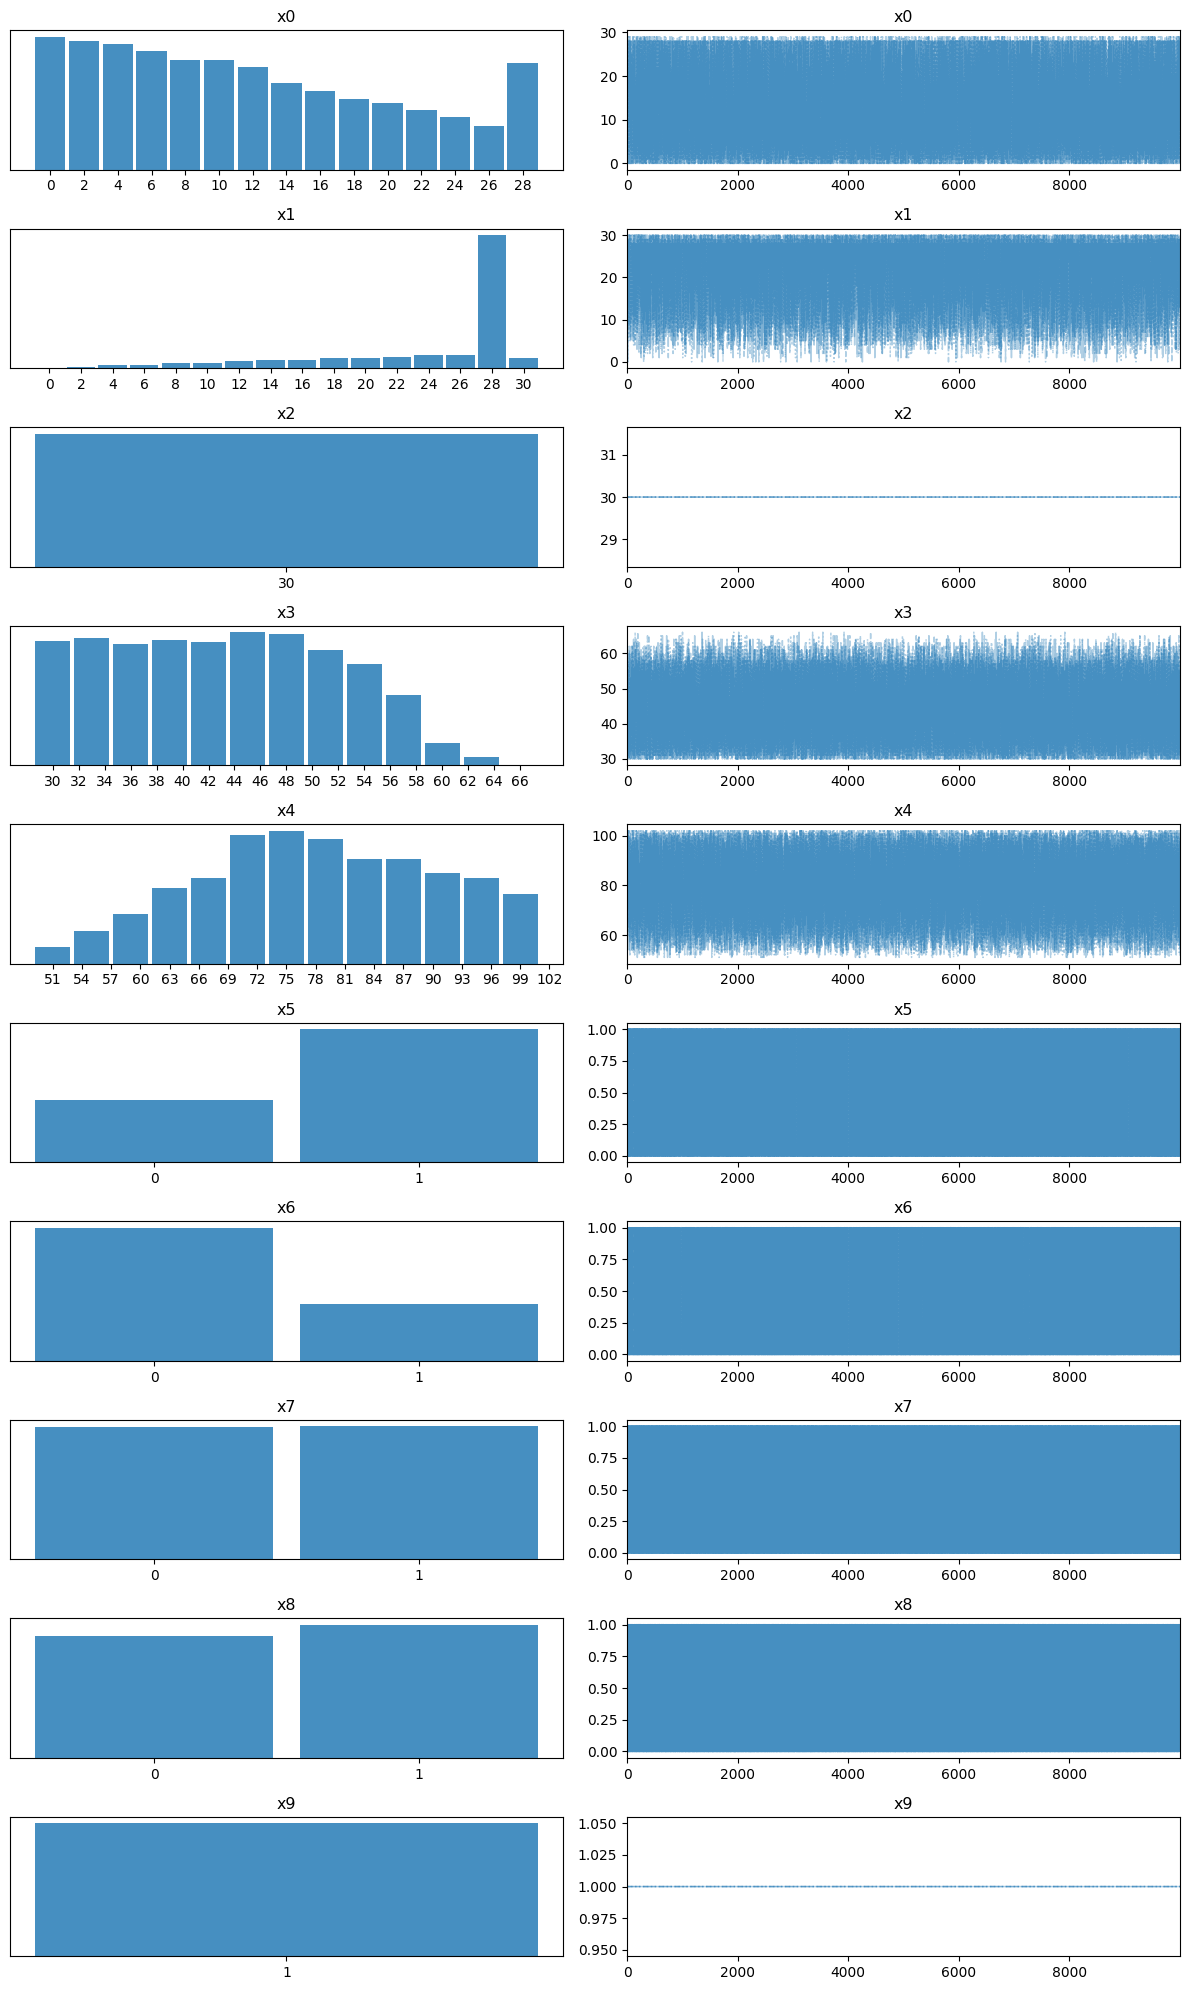

In [10]:
# Trace plot
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('spur_trace_plot.png', dpi=150);

In [12]:
# Diagnosis
az.summary(trace)

/home/pardo/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,12.129,8.588,0.0,28.0,0.043,0.030,40027.0,39095.0,1.0
x1,23.861,6.630,10.0,30.0,0.033,0.024,39465.0,39400.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,0.000,40000.0,40000.0,NaN
x3,44.056,8.624,30.0,57.0,0.043,0.030,40245.0,40320.0,1.0
x4,79.954,12.232,59.0,101.0,0.061,0.043,39774.0,38886.0,1.0
x5,0.684,0.465,0.0,1.0,0.002,0.002,39483.0,39483.0,1.0
x6,0.294,0.455,0.0,1.0,0.002,0.002,39307.0,39307.0,1.0
x7,0.515,0.500,0.0,1.0,0.003,0.002,38559.0,38559.0,1.0
x8,0.508,0.500,0.0,1.0,0.003,0.002,38685.0,38685.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,0.000,40000.0,40000.0,NaN
